## Pre-Preliminary Version

### Sampling Methods for Imbalanced Samples

#### Project for the Statistical Modelling Course - Felix Adam

- Discuss what class imbalances are, see discussion in Kuhn & Johnson
- Often the case that the class of interest, is severely underrepresented in the data
- Also called the "minority" class
- Example: Dataset on rare disease, which is found in 10 out of 1000 people
- Let's say we apply logistic regression to this problem to classify patients in healty and unhealty
- Use the dataset of 1000 observations, have some features, fit logistic regression
- Then we test the accuracy, it turns out to be very high lets's say 99% correctly predicted
- Is this a good classifier? We have to check whether the 99% are actually meaningful
- Potential issue: Classifier assigns every patient to the healthy class, which still results in accuracy of 99%
- Naive approach would be to ditch the classifier and just tell everyone that they're healthy, potentially devestating results
- The issue: With such an imbalanced dataset, classifiers tend to perform badly, since they 'learn' the features of the majority class

Ironically, predicting rare events is one of the most important and interesting tasks in classification. Luckily, there are some techniques for dealing with class imbalances. 

I will first discuss the issues that arise when not accounting for class imbalances. Then I'll present undersampling of the majority class as simple remedy. I will later extend this method to synthetic oversampling using the Synthetic Minority Oversampling Technique (SMOTE). In the last section I'll discuss further applications, benefits and shortfalls of the presented techniques and other options available.

1. Show the problem
2. Undersampling
3. Oversampling
4. SMOTE (+ Undersampling)
5. Simulations of all methods on the same datasets
6. Discussion, when to use what, information content of data, etc, when do these techniques NOT help?

In [113]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle

# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, mean_majority, sd_majority, cov_maj):
    
    """Helper function for creating classification problem with gaussians"""
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    #mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = ''):
    
    fig, ax = plt.subplots(1,1, figsize = (10,8))
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = ['Normal Wine','Bad Wine'], title = 'Confusion Matrix', cmap = plt.cm.Blues):
    
    " Helper function for plotting a confusion matrix"
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Helper function for correcting the intercept in models fitted on re-sampled data
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept
    


#### 1. The issue

- Relative frequency of the classes can have a significant impact on effectivness (Kuhn & Johnson)
- Often results in good specificity and bad sensitivity (Kuhn & Johnson)
- Examples can be found in many applications

Following i'll show an example in 2D space
- This example is chosen to demonstrate when class imbalances are of a particular issue (small seperation, etc)
- Followed by example of when class imbalance is less of an issue

##### Example in $R^2$

- My base rate is 1%, with a sample size of 5000, so only 50 instances of the minority class
- Gaussian features, let's assume that minority class is less disperesed than the majority
- Both clusters are relatively close to each other in terms of means of both features
- Covariance between features 0

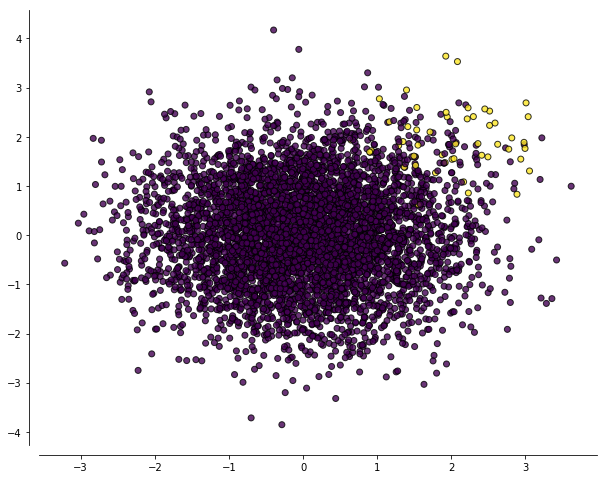

In [458]:
## Making the data ##

# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([2,2])
sd_minority = np.array([0.4,0.4])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority)


# Plot
plot_2d(x,y)

- One can see, that this is a hard problem in general, due to low seperation of both clusters.
- Will come back to the discussion of when class imbalance is actually a problem!
- Now follow the usual procedure of splitting the data into training and a testing set
- Split is done stratified, so that both sets have the same class distribution (base rate)
- Train the model on the training set
- Test model on the testing set

In [459]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)

In [491]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]
 
#### Take out later ####
# Get scores and display 
accuracy_baseline = metrics.accuracy_score(y_test, baseline_pred)
precision_baseline = metrics.precision_score(y_test, baseline_pred)
recall_baseline = metrics.recall_score(y_test, baseline_pred)

print(metrics.classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2475
         1.0       0.73      0.44      0.55        25

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.86      0.72      0.77      2500
weighted avg       0.99      0.99      0.99      2500



- We can see very high accuracy
- Relatively high precision
$\text{ Precision } = P [ y = 1 \mid \hat { y } = 1 ]$ <=>
$\text{Precision} = \frac{TP}{TP + FP}$
- If an instance is predicted to be of class 1, then it's quite likely to be true
- Recall is low
$\text{Recall} = P[\hat{y} = 1 \mid y = 1 ]$ <=>
$\text{Recall} = \frac{TP}{TP + FN}$
- Recall shows percentage of correctly classified positive cases, ability to find "interesting" cases

Check the confusion matrix to show the issue

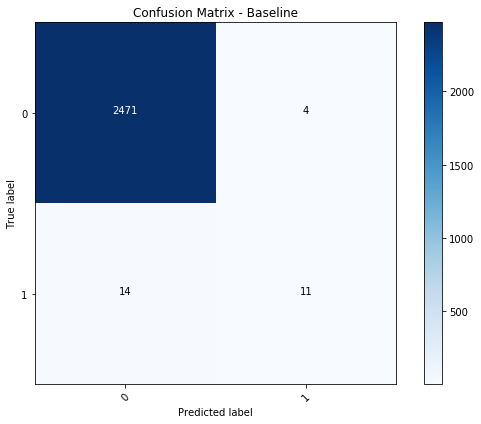

In [492]:
# Plot Confusion Matrix 
# Set plot size
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix using sklearn metrix
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'])

- Classifier is very good at finding members of the 0 class
- However, performance for class of interest is very low
- Depending on the issue, this could be devestating
- Maybe class 1 signifies rare diseases, miss-classifying these would be horrible
- What to focus on ultimately reverts back to the underlying problem
- Usually, identifiying the rare cases is the important task, otherwise it probably wouldn't be an important ML issue!
- Discuss shortly descision boundary!
- How does the decsision boundary for the classifier look like?

[(-5, 5), Text(0,0.5,'$X_2$'), (-5, 5), Text(0.5,0,'$X_1$'), None]

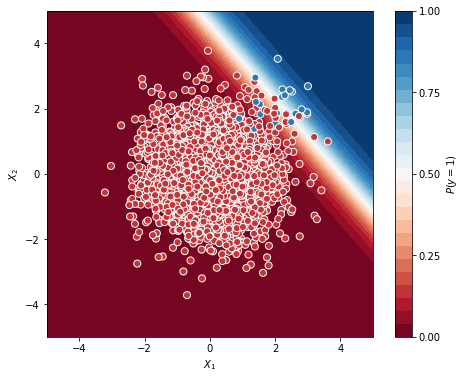

In [493]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = baseline_model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

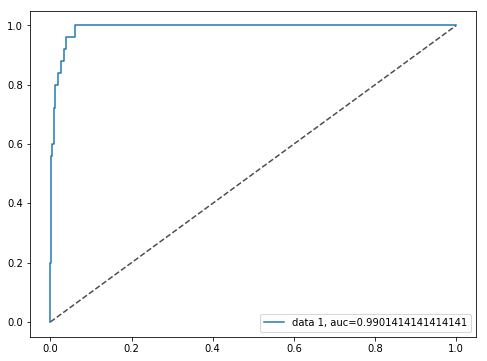

In [462]:
y_pred_proba = baseline_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

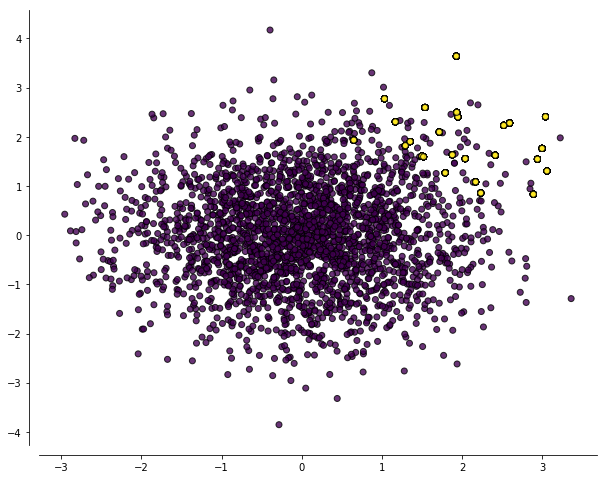

In [467]:
from imblearn import over_sampling 
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
oversampled_model.fit(X_oversampled, y_oversampled );

plot_2d(X_oversampled,y_oversampled)

##### NOW RE-WEIGHT THE LEARNED PROBABILITES!!! EXTREMLY IMPORTANT TO CHECK HERE #####
correct_intercept_logit(oversampled_model, y_train, y_oversampled)

In [468]:
# Make predictions on testing values
y_pred_oversampled = oversampled_model.predict(X_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_oversampled)
print(accuracy)

metrics.confusion_matrix(y_test,y_pred_oversampled)

0.9916


array([[2464,   11],
       [  10,   15]])

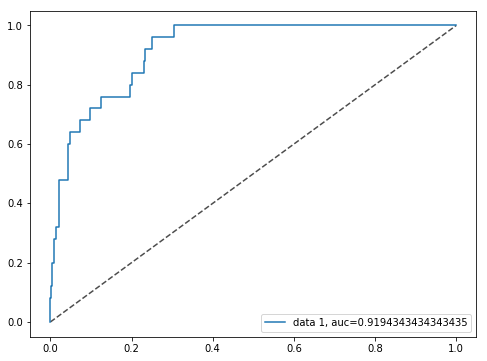

In [440]:
y_over_proba = oversampled_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_over_proba)
auc = metrics.roc_auc_score(y_test, y_over_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

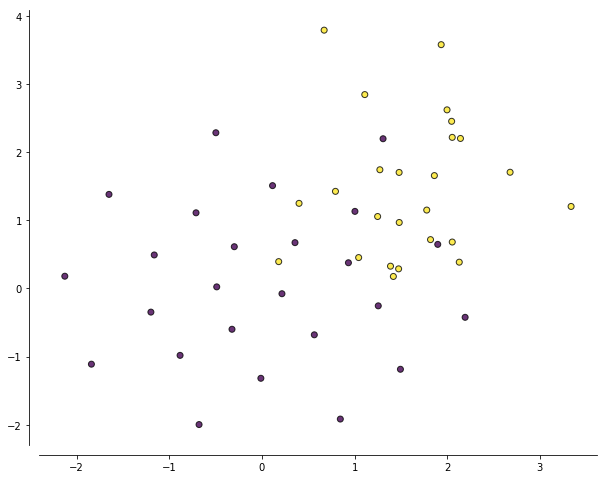

In [441]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_undersampled, y_undersampled = cc.fit_resample(X_train, y_train)

plot_2d(X_undersampled, y_undersampled)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
#undersampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
#undersampled_model.fit(X_undersampled, y_undersampled);


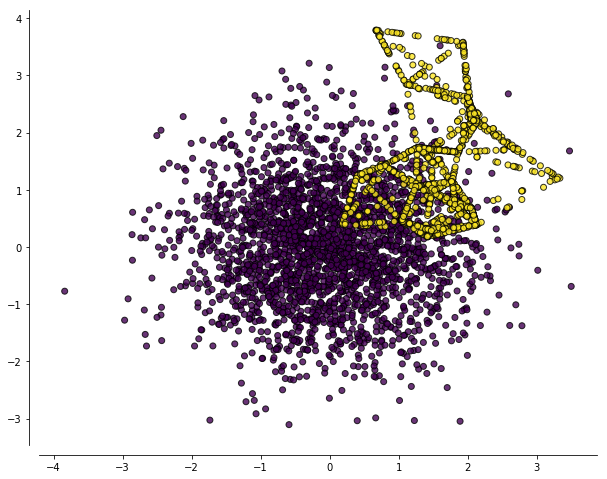

In [442]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors= 5, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(X_train,y_train)

plot_2d(x_smote,y_smote)

In [443]:
smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

# Make correction
correct_intercept_logit(smote_model, y_train, y_smote)

y_smote_proba = smote_model.predict_proba(X_test)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote)

0.8692


array([[2154,  321],
       [   6,   19]])

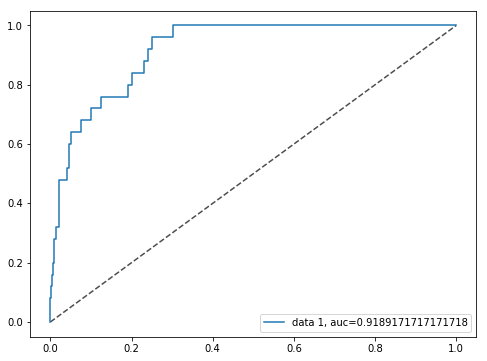

In [444]:
y_smote_proba = smote_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_smote_proba)
auc = metrics.roc_auc_score(y_test, y_smote_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[(-5, 5), Text(0,0.5,'$X_2$'), (-5, 5), Text(0.5,0,'$X_1$'), None]

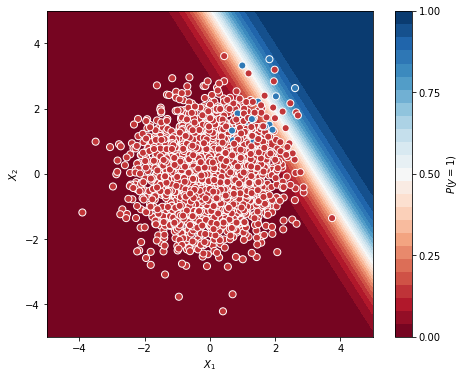

In [445]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = smote_model.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

In [169]:
from sklearn.datasets import make_classification

In [378]:
## Try in higher dimensional problem , using make classificatio
n =1000
base_rate = 0.01
x, y = make_classification(n_samples = n,n_features = 20, n_informative =5, n_redundant = 0, n_repeated =0,
                          n_classes = 2, n_clusters_per_class = 1, weights =  [1-base_rate,base_rate],
                          class_sep = 0.6)

In [379]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)

Baseline accuracy score: 0.986


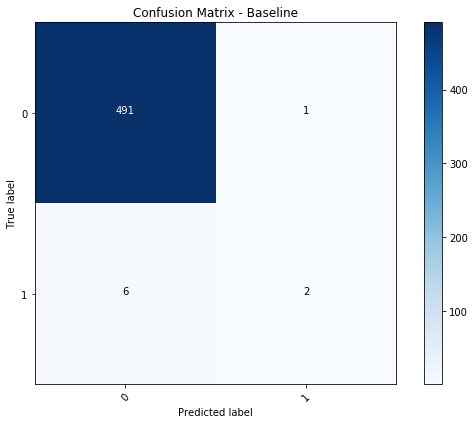

In [380]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]

# Accuracy
accuracy_baseline = metrics.accuracy_score(y_test,baseline_pred)

print('Baseline accuracy score: ' + str(round(accuracy_baseline,4)))

# Set plot size
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix using sklearn metrix
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'])

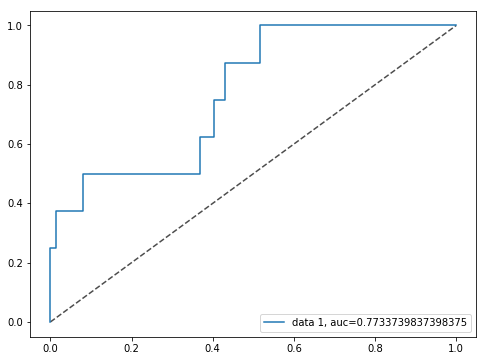

In [381]:
y_pred_proba = baseline_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [382]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors= 5, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(X_train,y_train)

smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

smote_model.intercept_


array([-1.28482225])

In [383]:
# Make correction
correct_intercept_logit(smote_model, y_train, y_smote)


y_smote_proba = smote_model.predict_proba(X_test)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote)

0.97


array([[482,  10],
       [  5,   3]])

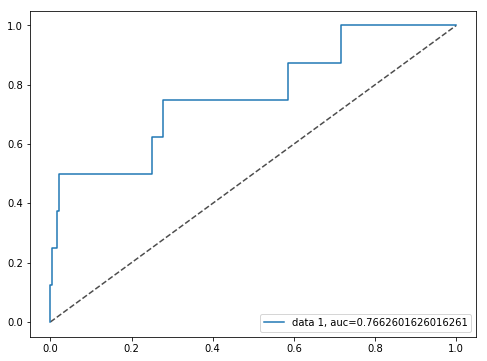

In [384]:
y_pred_proba = smote_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()